In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
bigp = ['AL', 'BNP', 'Jamaat', 'JaPa']
mainp = ['AL', 'BNP']
years = [1991, 1996, 2001, 2008]

In [3]:
dfs = pd.read_csv('data/seat_summary.csv')
dfs.head()

,seat,year,turnout,turnout_pc,voters,male_voters,female_voters,centers
0,Bagerhat-1,1991,128668.0,59.8,NaN,NaN,NaN,NaN
1,Bagerhat-2,1991,127664.0,61.3,NaN,NaN,NaN,NaN
2,Bagerhat-3,1991,99223.0,56.6,NaN,NaN,NaN,NaN
3,Barguna-1,1991,110705.0,45.3,NaN,NaN,NaN,NaN
4,Barguna-2,1991,69037.0,54.1,NaN,NaN,NaN,NaN


In [4]:
dfs.shape

(1607, 8)

In [5]:
# only take 1991-2008 election data
dfs = dfs[dfs.year.isin(years)]
dfs.shape

(1151, 8)

In [6]:
bdmap = gpd.read_file('map/seats.shp')
bdmap.head()

,seat_no,seat,district,division,region,shape_len,shape_area,geometry
0,1,Panchagarh-1,Panchagarh,Rangpur,Urban,2.787812,0.061199,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,2,Panchagarh-2,Panchagarh,Rangpur,Rural,1.411258,0.064286,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."
2,3,Thakurgaon-1,Thakurgaon,Rangpur,Urban,1.255212,0.058832,"POLYGON ((88.55589 26.17948, 88.55684 26.17788..."
3,4,Thakurgaon-2,Thakurgaon,Rangpur,Rural,1.858839,0.045806,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,..."
4,5,Thakurgaon-3,Thakurgaon,Rangpur,Rural,1.810654,0.059069,"POLYGON ((88.25475 26.03583, 88.25828 26.03391..."


In [7]:
# merge map data and seat summary data
df = pd.merge(bdmap, dfs, how='left', on='seat')[['seat', 'division', 'year', 'turnout_pc', 'geometry']]
df.head()

,seat,division,year,turnout_pc,geometry
0,Panchagarh-1,Rangpur,1991,62.10,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
1,Panchagarh-1,Rangpur,1996,81.81,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
2,Panchagarh-1,Rangpur,2001,86.15,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
3,Panchagarh-1,Rangpur,2008,91.70,"POLYGON ((88.72746 26.34527, 88.72772 26.34494..."
4,Panchagarh-2,Rangpur,1991,60.40,"POLYGON ((88.76158 26.30059, 88.76176 26.29971..."


### median

In [8]:
# group data by seats and count instances of each seat and median of turnout %
dfmed = df[['seat', 'year', 'turnout_pc']].groupby('seat').agg(count=('year', 'size'), tpc_med=('turnout_pc', 'median')).reset_index()
dfmed.head()

,seat,count,tpc_med
0,Bagerhat-1,4,82.30
1,Bagerhat-2,4,82.15
2,Bagerhat-3,4,78.65
3,Bagerhat-4,2,NaN
4,Bandarban,2,NaN


In [9]:
dfmed.shape

(300, 3)

In [10]:
# drop seats where instances count < 4
dfmed.drop(dfmed[dfmed['count'] < 4].index, inplace=True)
dfmed.head()

,seat,count,tpc_med
0,Bagerhat-1,4,82.30
1,Bagerhat-2,4,82.15
2,Bagerhat-3,4,78.65
5,Barguna-1,4,64.25
6,Barguna-2,4,72.10


In [11]:
dfmed.shape

(271, 3)

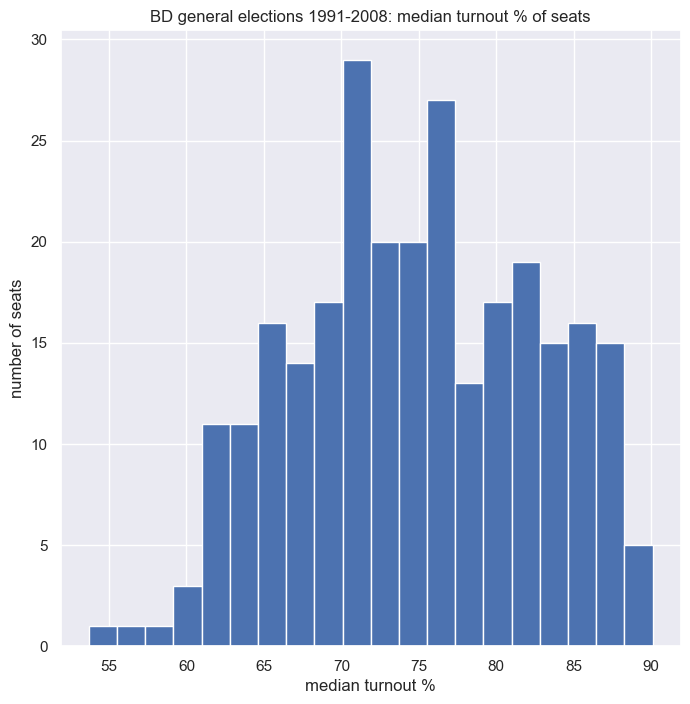

In [13]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 8))
dfmed['tpc_med'].hist(bins=20, ax=ax)
ax.set_title('BD general elections 1991-2008: median turnout % of seats')
ax.set_xlabel('median turnout %')
ax.set_ylabel('number of seats')
fig.savefig('fig/turnout_pc_med_hist',bbox_inches='tight')

In [14]:
# join data with map data
map_tpc = pd.merge(bdmap, dfmed, how='left', on='seat')[['seat', 'geometry', 'tpc_med']]
map_tpc.head()

,seat,geometry,tpc_med
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",83.98
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",80.90
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",83.00
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",81.60
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",82.40


In [15]:
map_tpc[['seat', 'tpc_med']].rename(columns={
    'tpc_med': 'turnout_pc_med'
}).to_csv('dataout/turnout_pc_med.csv', index=False)

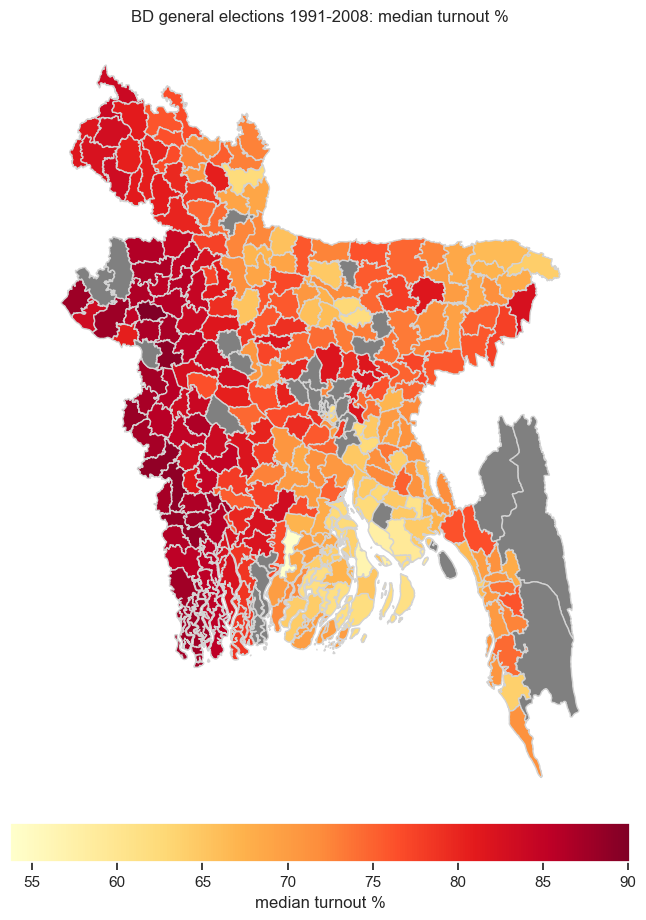

In [17]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_tpc.plot(
    column='tpc_med', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'median turnout %',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: median turnout %")
fig.savefig('fig/turnout_pc_med_map',bbox_inches='tight')

### median of each division

In [18]:
# find median turnout % of each division
tpc_med_div = df[['division', 'turnout_pc']].groupby('division').median()['turnout_pc']

In [19]:
# join data with map data
map_tpc_div = pd.merge(bdmap, tpc_med_div, how='left', left_on='division', right_index=True)[['seat', 'division', 'geometry', 'turnout_pc']]
map_tpc_div.head()

,seat,division,geometry,turnout_pc
0,Panchagarh-1,Rangpur,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",76.85
1,Panchagarh-2,Rangpur,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",76.85
2,Thakurgaon-1,Rangpur,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",76.85
3,Thakurgaon-2,Rangpur,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",76.85
4,Thakurgaon-3,Rangpur,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",76.85


In [20]:
map_tpc_div[['seat', 'division', 'turnout_pc']].rename(columns={
    'turnout_pc': 'turnout_pc_med'
}).to_csv('dataout/turnout_pc_div_med.csv', index=False)

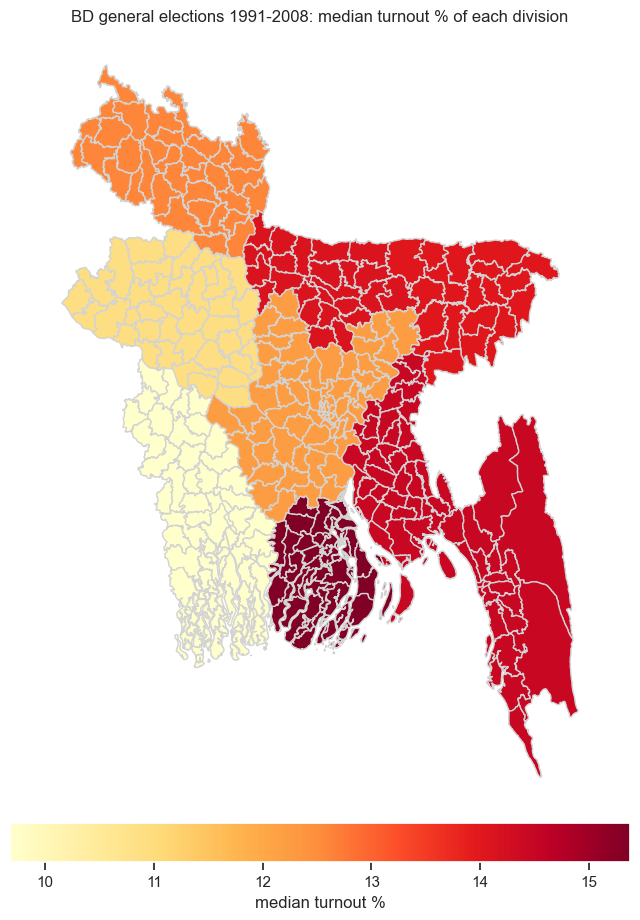

In [35]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_tpc_div.plot(
    column='turnout_pc', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'median turnout %',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: median turnout % of each division")
fig.savefig('fig/turnout_pc_med_div_map',bbox_inches='tight')

### stdev

In [22]:
# group data by seats and count instances of each seat and stdev of turnout %
dfvar = df[['seat', 'year', 'turnout_pc']].groupby('seat').agg(count=('year', 'size'), tpc_var=('turnout_pc', 'var')).reset_index()
dfvar.head()

,seat,count,tpc_var
0,Bagerhat-1,4,165.956667
1,Bagerhat-2,4,144.230000
2,Bagerhat-3,4,191.326667
3,Bagerhat-4,2,NaN
4,Bandarban,2,NaN


In [23]:
dfvar.shape

(300, 3)

In [24]:
# drop seats where instances count < 4
dfvar.drop(dfvar[dfvar['count'] < 4].index, inplace=True)
dfvar.head()

,seat,count,tpc_var
0,Bagerhat-1,4,165.956667
1,Bagerhat-2,4,144.230000
2,Bagerhat-3,4,191.326667
5,Barguna-1,4,230.049167
6,Barguna-2,4,172.090000


In [25]:
dfvar.shape

(271, 3)

In [26]:
dfvar['tpc_std'] = dfvar['tpc_var'].pow(1./2)
dfvar.head()

,seat,count,tpc_var,tpc_std
0,Bagerhat-1,4,165.956667,12.882417
1,Bagerhat-2,4,144.230000,12.009580
2,Bagerhat-3,4,191.326667,13.832088
5,Barguna-1,4,230.049167,15.167372
6,Barguna-2,4,172.090000,13.118308


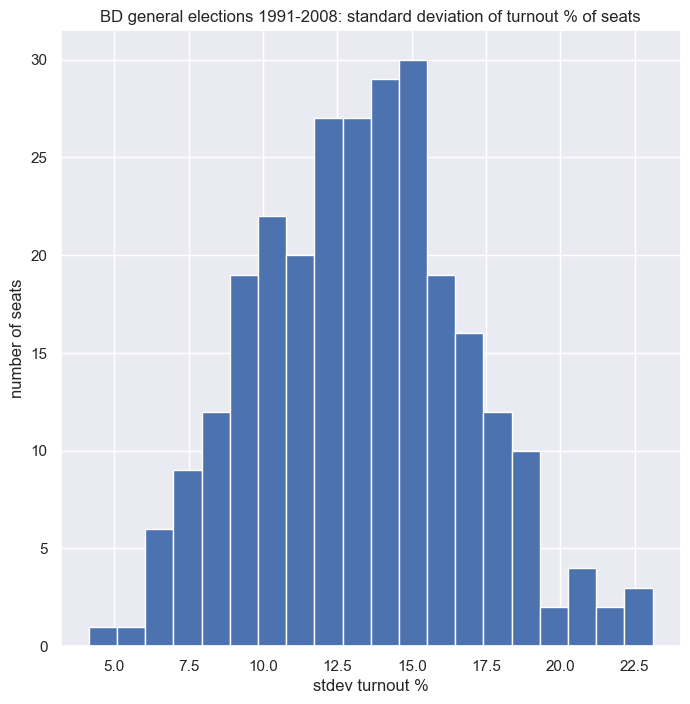

In [27]:
# plot histogram
fig, ax = plt.subplots(figsize=(8, 8))
dfvar['tpc_std'].hist(bins=20, ax=ax)
ax.set_title('BD general elections 1991-2008: standard deviation of turnout % of seats')
ax.set_xlabel('stdev turnout %')
ax.set_ylabel('number of seats')
fig.savefig('fig/turnout_pc_std_hist',bbox_inches='tight')

In [28]:
# join data with map data
map_tpc_std = pd.merge(bdmap, dfvar, how='left', on='seat')[['seat', 'geometry', 'tpc_std']]
map_tpc_std.head()

,seat,geometry,tpc_std
0,Panchagarh-1,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",12.879237
1,Panchagarh-2,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",13.955883
2,Thakurgaon-1,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",10.361229
3,Thakurgaon-2,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",12.322743
4,Thakurgaon-3,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",10.094883


In [29]:
map_tpc_std[['seat', 'tpc_std']].rename(columns={
    'tpc_std': 'turnout_pc_std'
}).to_csv('dataout/turnout_pc_std.csv', index=False)

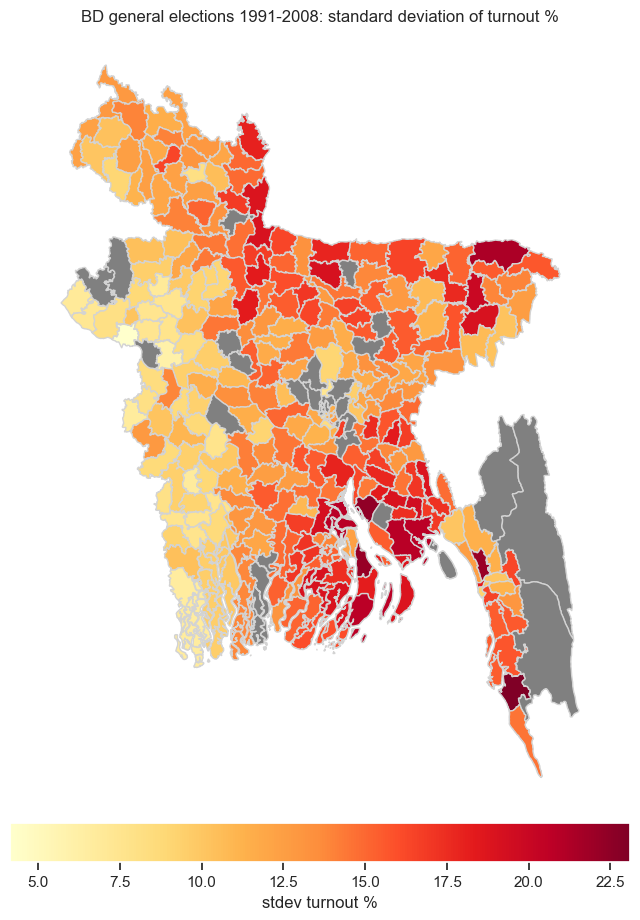

In [30]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_tpc_std.plot(
    column='tpc_std', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'stdev turnout %',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: standard deviation of turnout %")
fig.savefig('fig/turnout_pc_std_map',bbox_inches='tight')

### stdev of each division

In [31]:
# find stdev of turnout % of each division
tpc_var_div = df[['division', 'turnout_pc']].groupby('division').var()['turnout_pc']
tpc_std_div = tpc_var_div.pow(1./2)

In [32]:
# join data with map data
map_tpc_div = pd.merge(bdmap, tpc_std_div, how='left', left_on='division', right_index=True)[['seat', 'division', 'geometry', 'turnout_pc']]
map_tpc_div.head()

,seat,division,geometry,turnout_pc
0,Panchagarh-1,Rangpur,"POLYGON ((88.72746 26.34527, 88.72772 26.34494...",12.616058
1,Panchagarh-2,Rangpur,"POLYGON ((88.76158 26.30059, 88.76176 26.29971...",12.616058
2,Thakurgaon-1,Rangpur,"POLYGON ((88.55589 26.17948, 88.55684 26.17788...",12.616058
3,Thakurgaon-2,Rangpur,"POLYGON ((88.32191 26.20205, 88.3222 26.20129,...",12.616058
4,Thakurgaon-3,Rangpur,"POLYGON ((88.25475 26.03583, 88.25828 26.03391...",12.616058


In [33]:
map_tpc_div[['seat', 'division', 'turnout_pc']].rename(columns={
    'turnout_pc': 'turnout_pc_std'
}).to_csv('dataout/turnout_pc_div_std.csv', index=False)

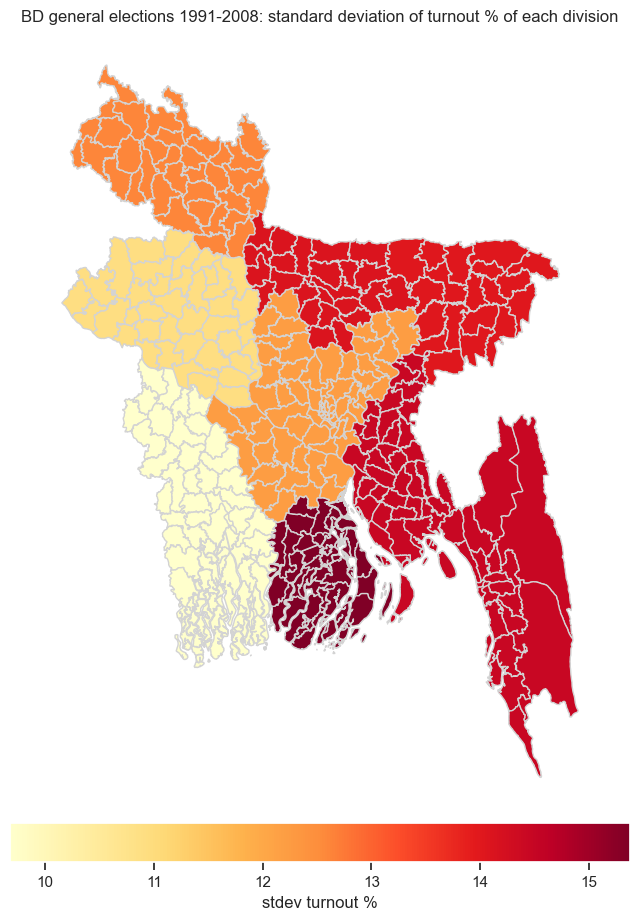

In [34]:
# plot map
fig, ax = plt.subplots(figsize=(8, 14))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

map_tpc_div.plot(
    column='turnout_pc', 
    cmap='YlOrRd', 
    edgecolor='lightgrey',
    legend=True, 
    ax=ax,
    cax=cax,
    missing_kwds={
        "color": "grey",
        "label": "missing data",
    }, 
    legend_kwds={
    'label': 'stdev turnout %',
    'orientation': 'horizontal'
    },
)
ax.set_axis_off()
ax.title.set_text("BD general elections 1991-2008: standard deviation of turnout % of each division")
fig.savefig('fig/turnout_pc_std_div_map',bbox_inches='tight')